In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [3]:
import os
print(os.getcwd())

/Users/bananavodka/Projects/at2_mla/at2_mla/notebooks/predictive


In [4]:
# Load the datasets
sales_train_df = pd.read_csv('/Users/bananavodka/Projects/at2_mla/at2_mla/data/raw/sales_train.csv')
calendar_df = pd.read_csv('/Users/bananavodka/Projects/at2_mla/at2_mla/data/raw/calendar.csv')
calendar_events_df = pd.read_csv('/Users/bananavodka/Projects/at2_mla/at2_mla/data/raw/calendar_events.csv')
sales_test_df = pd.read_csv('/Users/bananavodka/Projects/at2_mla/at2_mla/data/raw/sales_test.csv')
items_weekly_sales_df = pd.read_csv('/Users/bananavodka/Projects/at2_mla/at2_mla/data/raw/items_weekly_sell_prices.csv')

In [5]:
# Display the first few rows of each dataset to ensure successful loading
print("Sales Training Data:")
print(sales_train_df.head())

Sales Training Data:
                              id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_evaluation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_evaluation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_evaluation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  ...  d_1532  d_1533  d_1534  d_1535  d_1536  \
0       CA    0    0    0    0  ...       1       1       1       0       1   
1       CA    0    0    0    0  ...       0       0       0       0       0   
2       CA    0    0    0    0  ...       0       0       1       0       0   
3       CA    0    0    0    0  ...       8       2       0       8       2   
4       CA    0    0    0    0  ...       2       0       1       3       2   

   d_1537  d_1538  d_15

In [6]:
print("\nCalendar Data:")
print(calendar_df.head())


Calendar Data:
         date  wm_yr_wk    d
0  2011-01-29     11101  d_1
1  2011-01-30     11101  d_2
2  2011-01-31     11101  d_3
3  2011-02-01     11101  d_4
4  2011-02-02     11101  d_5


In [7]:
print("\nCalendar Events Data:")
print(calendar_events_df.head())


Calendar Events Data:
         date     event_name event_type
0  2011-02-06      SuperBowl   Sporting
1  2011-02-14  ValentinesDay   Cultural
2  2011-02-21  PresidentsDay   National
3  2011-03-09      LentStart  Religious
4  2011-03-16      LentWeek2  Religious


In [8]:
print("\nSales Test Data:")
print(sales_test_df.head())


Sales Test Data:
   d_1542  d_1543  d_1544  d_1545  d_1546  d_1547  d_1548  d_1549  d_1550  \
0       0       1       0       2       1       0       2       0       1   
1       0       0       0       0       0       0       0       0       1   
2       0       0       0       0       0       1       0       0       0   
3       4       1       0       1       3       5       2       3       0   
4       3       0       0       1       1       0       2       0       2   

   d_1551  ...  d_1932  d_1933  d_1934  d_1935  d_1936  d_1937  d_1938  \
0       0  ...       2       4       0       0       0       0       3   
1       0  ...       0       1       2       1       1       0       0   
2       0  ...       1       0       2       0       0       0       2   
3       2  ...       1       1       0       4       0       1       3   
4       1  ...       0       0       0       2       1       0       0   

   d_1939  d_1940  d_1941  
0       3       0       1  
1       0       0 

In [9]:
# Melt the sales data to long format
sales_train_melted = pd.melt(
    sales_train_df,
    id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
    var_name='d',
    value_name='sales'
)

In [10]:
# Merge sales data with calendar data on the 'd' column
sales_train_merged = pd.merge(sales_train_melted, calendar_df, how='left', on='d')

In [11]:
# Merge sales data with event data on the 'date' column
sales_train_with_events = pd.merge(sales_train_merged, calendar_events_df, how='left', on='date')

In [12]:
# Merge sales data with item prices based on 'wm_yr_wk', 'item_id', and 'store_id'
sales_train_with_prices = pd.merge(sales_train_with_events, items_weekly_sales_df, how='left', on=['item_id', 'store_id', 'wm_yr_wk'])

In [13]:
# Fill missing event names and types with placeholders
sales_train_with_prices['event_name'].fillna('No Event', inplace=True)
sales_train_with_prices['event_type'].fillna('None', inplace=True)

In [14]:
# Forward-fill missing prices (carry forward the last known price)
sales_train_with_prices['sell_price'].fillna(method='ffill', inplace=True)

In [15]:
# If there's still any remaining missing price values, fill them with the mean price of the item
sales_train_with_prices['sell_price'].fillna(
    sales_train_with_prices.groupby('item_id')['sell_price'].transform('mean'), 
    inplace=True
)

In [16]:
sales_train_with_prices.isnull().sum().sum()

0

In [17]:
sales_train_with_prices.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47107050 entries, 0 to 47107049
Data columns (total 13 columns):
 #   Column      Dtype  
---  ------      -----  
 0   id          object 
 1   item_id     object 
 2   dept_id     object 
 3   cat_id      object 
 4   store_id    object 
 5   state_id    object 
 6   d           object 
 7   sales       int64  
 8   date        object 
 9   wm_yr_wk    int64  
 10  event_name  object 
 11  event_type  object 
 12  sell_price  float64
dtypes: float64(1), int64(2), object(10)
memory usage: 4.9+ GB


In [18]:
# Convert 'date' to datetime
sales_train_with_prices['date'] = pd.to_datetime(sales_train_with_prices['date'])

In [19]:
# Create date-based features
sales_train_with_prices['day'] = sales_train_with_prices['date'].dt.day
sales_train_with_prices['month'] = sales_train_with_prices['date'].dt.month
sales_train_with_prices['weekday'] = sales_train_with_prices['date'].dt.weekday

In [20]:
sales_train_with_prices.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47107050 entries, 0 to 47107049
Data columns (total 16 columns):
 #   Column      Dtype         
---  ------      -----         
 0   id          object        
 1   item_id     object        
 2   dept_id     object        
 3   cat_id      object        
 4   store_id    object        
 5   state_id    object        
 6   d           object        
 7   sales       int64         
 8   date        datetime64[ns]
 9   wm_yr_wk    int64         
 10  event_name  object        
 11  event_type  object        
 12  sell_price  float64       
 13  day         int64         
 14  month       int64         
 15  weekday     int64         
dtypes: datetime64[ns](1), float64(1), int64(5), object(9)
memory usage: 6.0+ GB


In [21]:
# Create label encoders for categorical features
encoder_store = LabelEncoder()
encoder_item = LabelEncoder()

In [22]:
sales_train_with_prices['store_id'] = encoder_store.fit_transform(sales_train_with_prices['store_id'])
sales_train_with_prices['item_id'] = encoder_item.fit_transform(sales_train_with_prices['item_id'])

In [23]:
# Initialize label encoders for event names and types
le_event_name = LabelEncoder()
le_event_type = LabelEncoder()

In [24]:
sales_train_with_prices['event_name_encoded'] = le_event_name.fit_transform(sales_train_with_prices['event_name'])
sales_train_with_prices['event_type_encoded'] = le_event_type.fit_transform(sales_train_with_prices['event_type'])

In [25]:
# Aggregate total daily sales across all stores and items
sales_data = sales_train_with_prices.groupby('date').agg({'sales': 'sum'}).reset_index()

In [26]:
# Rename columns to match Prophet's expected format
sales_data.rename(columns={'date': 'ds', 'sales': 'y'}, inplace=True)

In [27]:
# Display the first few rows
print(sales_data.head())

          ds      y
0 2011-01-29  32631
1 2011-01-30  31749
2 2011-01-31  23783
3 2011-02-01  25412
4 2011-02-02  19146


In [28]:
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [29]:
# Initialize the Prophet model
prophet_model = Prophet()

In [30]:
# Fit the model on the sales data
prophet_model.fit(sales_data)

12:07:14 - cmdstanpy - INFO - Chain [1] start processing
12:07:14 - cmdstanpy - INFO - Chain [1] done processing


In [31]:
# Display the first few rows to ensure the model trained correctly
print(sales_data.head())

          ds      y
0 2011-01-29  32631
1 2011-01-30  31749
2 2011-01-31  23783
3 2011-02-01  25412
4 2011-02-02  19146


In [32]:
# Create a dataframe for the next 7 days
future_dates = prophet_model.make_future_dataframe(periods=7)

In [33]:
# Make predictions
forecast = prophet_model.predict(future_dates)

In [34]:
# Display the forecasted values
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7))

             ds          yhat    yhat_lower    yhat_upper
1541 2015-04-19  43406.839464  38382.363086  47972.110999
1542 2015-04-20  34755.405185  30026.090590  39356.080397
1543 2015-04-21  32354.027674  27719.652843  37568.574406
1544 2015-04-22  31946.385414  26764.922777  36611.069871
1545 2015-04-23  32017.665288  27223.390555  36885.437435
1546 2015-04-24  36124.125229  31277.370257  40962.397860
1547 2015-04-25  43152.995340  38001.934446  47966.702285


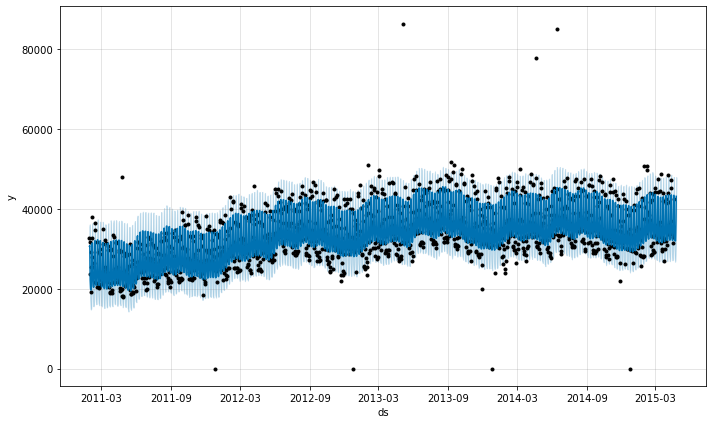

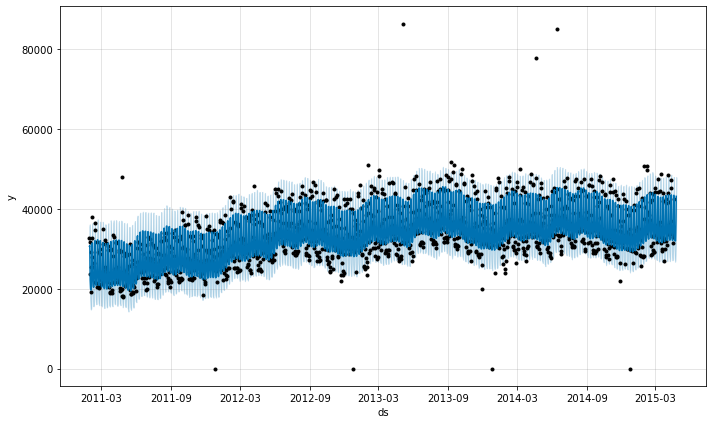

In [35]:
# Plot the forecast
prophet_model.plot(forecast)

In [36]:
import joblib

In [37]:
# Save the Prophet model
save_path = "/Users/bananavodka/Projects/at2_mla/at2_mla/models/forecasting"

#full path where the Prophet model will be saved
model_save_path = os.path.join(save_path, "prophet_model.pkl")

In [38]:
# Save the trained Prophet model using joblib
joblib.dump(prophet_model, model_save_path)

['/Users/bananavodka/Projects/at2_mla/at2_mla/models/forecasting/prophet_model.pkl']

In [39]:
print(f"Prophet model saved to {model_save_path}")

Prophet model saved to /Users/bananavodka/Projects/at2_mla/at2_mla/models/forecasting/prophet_model.pkl
